# NBA Player Analysis: Are the type of players changing?

# Imports

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Resources

Data:

https://www.kaggle.com/abhinavp23/nba-stats-player-and-team

Other Projects:

https://randerson112358.medium.com/nba-data-analysis-exploration-9293f311e0e8

https://dribbleanalytics.blog/2019/04/positional-clustering/

http://suruchifialoke.com/2017-06-01-clustering-nba-players/

Rule Changes:

https://cdn.nba.net/nba-drupal-prod/nba-rules-changes-history.pdf

# Load Data

In [26]:
data = pd.read_csv('../data/NBA_Season_Stats.csv')

In [27]:
data.shape

(27943, 31)

In [28]:
data.sort_values('Year', inplace=True)

# Clean Data

In [29]:
# Removes second index column.
data.drop(labels='Unnamed: 0', axis=1, inplace=True)

In [30]:
# Removes rows with null values.
data.dropna(axis=0, inplace=True)

In [31]:
data.shape

(17363, 30)

In [32]:
# Strips * from names and records each player that was in the Hall of Fame as 1 and 0 otherwise.
players = []
hf = []

for player_name in data['Player']:
    if player_name.endswith('*'):
        players.append(player_name.strip('*'))
        hf.append(1)
    else:
        players.append(player_name)
        hf.append(0)

In [33]:
len(players)

17363

In [34]:
len(hf)

17363

In [35]:
# Replaces column, Player, with stripped names.
# Adds column, HF, to indicate whether or not a player was inducted into the Hall of Fame
data['Player'] = players
data['HF'] = hf

In [36]:
data.head()

,Year,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,HF
5919,1980.0,Pete Maravich,SG,32.0,BOS,26.0,4.0,442.0,123.0,249.0,...,10.0,28.0,38.0,29.0,9.0,2.0,37.0,49.0,299.0,1
5917,1980.0,Pete Maravich,SG,32.0,TOT,43.0,4.0,964.0,244.0,543.0,...,17.0,61.0,78.0,83.0,24.0,6.0,82.0,79.0,589.0,1
5974,1980.0,Rick Robey,C,24.0,BOS,82.0,27.0,1918.0,379.0,727.0,...,209.0,321.0,530.0,92.0,53.0,15.0,151.0,244.0,942.0,0
5700,1980.0,Tiny Archibald,PG,31.0,BOS,80.0,80.0,2864.0,383.0,794.0,...,59.0,138.0,197.0,671.0,106.0,10.0,242.0,218.0,1131.0,1
5756,1980.0,Don Chaney,SG,33.0,BOS,60.0,0.0,523.0,67.0,189.0,...,31.0,42.0,73.0,38.0,31.0,11.0,33.0,80.0,167.0,0


In [37]:
data.columns

Index(['Year', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA',
       'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA',
       'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS',
       'HF'],
      dtype='object')

In [38]:
# Sums up player's season stats if they were traded within a season.
players = data.groupby(['Year', 'Player', 'Pos'])[['G', 'GS', 'MP', 'FG', 'FGA',
       'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA',
       'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']].sum().reset_index()

In [39]:
# Adds the column, HF.
players['HF'] = data.groupby(['Year', 'Player', 'Pos'])['HF'].max().reset_index()['HF']

In [40]:
players

,Year,Player,Pos,G,GS,MP,FG,FGA,FG%,3P,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,HF
0,1980.0,Chris Ford,SG,73.0,73.0,2115.0,330.0,709.0,0.465,70.0,...,77.0,104.0,181.0,215.0,111.0,27.0,105.0,178.0,816.0,0
1,1980.0,Dave Cowens,C,66.0,55.0,2159.0,422.0,932.0,0.453,1.0,...,126.0,408.0,534.0,206.0,69.0,61.0,108.0,216.0,940.0,1
2,1980.0,Don Chaney,SG,60.0,0.0,523.0,67.0,189.0,0.354,1.0,...,31.0,42.0,73.0,38.0,31.0,11.0,33.0,80.0,167.0,0
3,1980.0,Gerald Henderson,PG,76.0,2.0,1061.0,191.0,382.0,0.500,2.0,...,37.0,46.0,83.0,147.0,45.0,15.0,109.0,96.0,473.0,0
4,1980.0,Jeff Judkins,SF,65.0,0.0,674.0,139.0,276.0,0.504,11.0,...,32.0,34.0,66.0,47.0,29.0,5.0,49.0,91.0,351.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13719,2019.0,Zach Collins,C,77.0,0.0,17.6,2.5,5.2,0.473,0.5,...,1.4,2.8,4.2,0.9,0.3,0.9,1.0,2.3,6.6,0
13720,2019.0,Zach LaVine,SG,63.0,62.0,34.5,8.4,18.0,0.467,1.9,...,0.6,4.0,4.7,4.5,1.0,0.4,3.4,2.2,23.7,0
13721,2019.0,Zaza Pachulia,C,68.0,3.0,12.9,1.3,2.8,0.440,0.0,...,1.5,2.4,3.9,1.3,0.5,0.3,0.8,2.2,3.9,0
13722,2019.0,Zhaire Smith,SG,6.0,2.0,18.5,2.3,5.7,0.412,1.0,...,0.5,1.7,2.2,1.7,0.3,0.3,1.0,1.3,6.7,0


In [41]:
# Recalculates the percentage columns.
players['FG%'] = players['FG']/players['FGA']
players['FT%'] = players['FT']/players['FTA']
players['3P%'] = players['3P']/players['3PA']
players['2P%'] = players['2P']/players['2PA']
players['eFG%'] = (players['FG'] + 0.5*players['3P'])/players['FGA']

In [42]:
# Changes the year column to an integer
players['Year'] = players['Year'].astype(int)

In [43]:
# Transforms categorical column, Pos, into dummy variables.
players = pd.get_dummies(players, columns=['Pos'])

In [44]:
# Shape of new dataframe.
players.shape

(13724, 44)

In [45]:
# Drops any leftover null values.
players.dropna(axis=0, inplace=True)

In [46]:
players

,Year,Player,G,GS,MP,FG,FGA,FG%,3P,3PA,...,Pos_PG,Pos_PG-SF,Pos_PG-SG,Pos_SF,Pos_SF-PF,Pos_SF-SG,Pos_SG,Pos_SG-PF,Pos_SG-PG,Pos_SG-SF
0,1980,Chris Ford,73.0,73.0,2115.0,330.0,709.0,0.465444,70.0,164.0,...,0,0,0,0,0,0,1,0,0,0
1,1980,Dave Cowens,66.0,55.0,2159.0,422.0,932.0,0.452790,1.0,12.0,...,0,0,0,0,0,0,0,0,0,0
2,1980,Don Chaney,60.0,0.0,523.0,67.0,189.0,0.354497,1.0,6.0,...,0,0,0,0,0,0,1,0,0,0
3,1980,Gerald Henderson,76.0,2.0,1061.0,191.0,382.0,0.500000,2.0,6.0,...,1,0,0,0,0,0,0,0,0,0
4,1980,Jeff Judkins,65.0,0.0,674.0,139.0,276.0,0.503623,11.0,27.0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13719,2019,Zach Collins,77.0,0.0,17.6,2.5,5.2,0.480769,0.5,1.6,...,0,0,0,0,0,0,0,0,0,0
13720,2019,Zach LaVine,63.0,62.0,34.5,8.4,18.0,0.466667,1.9,5.1,...,0,0,0,0,0,0,1,0,0,0
13721,2019,Zaza Pachulia,68.0,3.0,12.9,1.3,2.8,0.464286,0.0,0.1,...,0,0,0,0,0,0,0,0,0,0
13722,2019,Zhaire Smith,6.0,2.0,18.5,2.3,5.7,0.403509,1.0,2.7,...,0,0,0,0,0,0,1,0,0,0


In [47]:
# Splits data on 1999 where the five second rule was implemented.
# Five second rule makes the game go faster forcing players to make decisions faster.
pre_rule = players[players['Year']<=1999]
post_rule = players[players['Year']>1999]

In [48]:
pre_rule.shape

(5578, 44)

In [49]:
post_rule.shape

(8108, 44)

# EDA

In [50]:
players.columns

Index(['Year', 'Player', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA',
       '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB',
       'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'HF', 'Pos_C',
       'Pos_C-PF', 'Pos_C-SF', 'Pos_PF', 'Pos_PF-C', 'Pos_PF-SF', 'Pos_PG',
       'Pos_PG-SF', 'Pos_PG-SG', 'Pos_SF', 'Pos_SF-PF', 'Pos_SF-SG', 'Pos_SG',
       'Pos_SG-PF', 'Pos_SG-PG', 'Pos_SG-SF'],
      dtype='object')

In [51]:
pos_pre = pre_rule[['Pos_C',
       'Pos_C-PF', 'Pos_C-SF', 'Pos_PF', 'Pos_PF-C', 'Pos_PF-SF', 'Pos_PG',
       'Pos_PG-SF', 'Pos_PG-SG', 'Pos_SF', 'Pos_SF-PF', 'Pos_SF-SG', 'Pos_SG',
       'Pos_SG-PF', 'Pos_SG-PG', 'Pos_SG-SF']]
pos_post = post_rule[['Pos_C',
       'Pos_C-PF', 'Pos_C-SF', 'Pos_PF', 'Pos_PF-C', 'Pos_PF-SF', 'Pos_PG',
       'Pos_PG-SF', 'Pos_PG-SG', 'Pos_SF', 'Pos_SF-PF', 'Pos_SF-SG', 'Pos_SG',
       'Pos_SG-PF', 'Pos_SG-PG', 'Pos_SG-SF']]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  


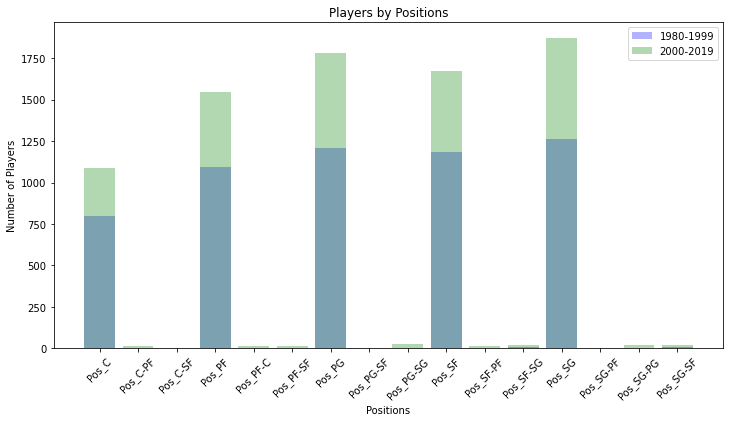

In [52]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(pos_pre.columns, pos_pre.sum(), color='blue', alpha=0.3, label='1980-1999')
ax.bar(pos_post.columns, pos_post.sum(), color='green', alpha=0.3, label='2000-2019')

ax.set_title('Players by Positions')
ax.set_xlabel('Positions')
ax.set_ylabel('Number of Players')
ax.set_xticklabels(pos_pre.columns, rotation=45)

ax.legend();

__There are more players overall, which is to be expected since the organization is growing. However, there appears to be more of these 'flexible' players that can play more than one position.__

__C__: Center, 5 (ie. Shaquille O'Neal)

__PF__: Power Foward, 4 (ie. Chris Bosh)

__SF__: Small Foward, 3 (ie. Kawhi Leonard)

__SG__: Shooting Guard, 2 (ie. Klay Thompson)

__PG__: Point Guard, 1 (ie. Stephen Curry)

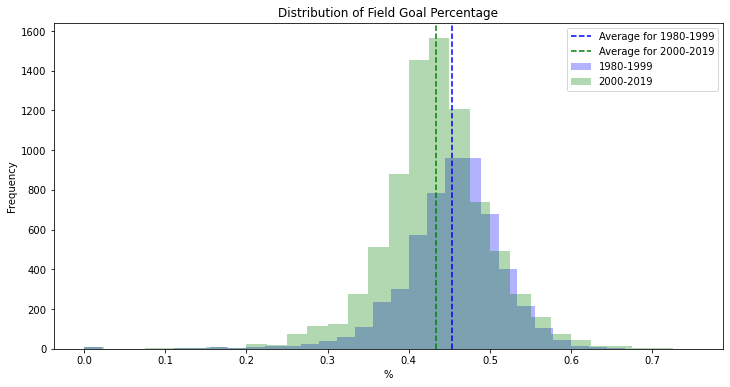

In [53]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(pre_rule['FG%'], bins=30, color='blue', alpha=0.3, label='1980-1999')
ax.hist(post_rule['FG%'], bins=30, color='green', alpha=0.3, label='2000-2019')

ax.axvline(pre_rule['FG%'].mean(), color='blue', linestyle='dashed', label='Average for 1980-1999')
ax.axvline(post_rule['FG%'].mean(), color='green', linestyle='dashed', label='Average for 2000-2019')

ax.set_title('Distribution of Field Goal Percentage')
ax.set_xlabel('%')
ax.set_ylabel('Frequency')

ax.legend();

__It appears that the field goal percentage decreased.__

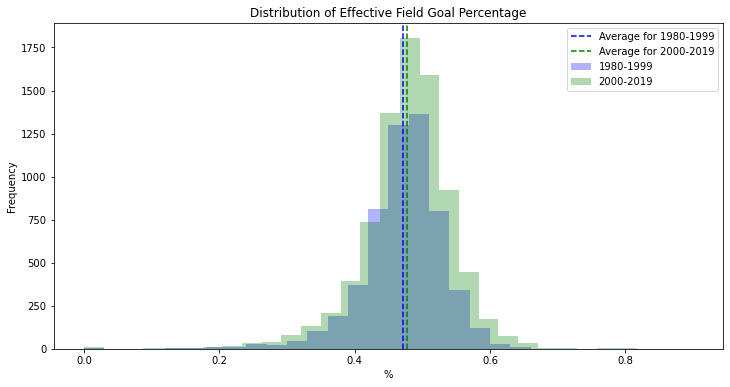

In [54]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(pre_rule['eFG%'], bins=30, color='blue', alpha=0.3, label='1980-1999')
ax.hist(post_rule['eFG%'], bins=30, color='green', alpha=0.3, label='2000-2019')

ax.axvline(pre_rule['eFG%'].mean(), color='blue', linestyle='dashed', label='Average for 1980-1999')
ax.axvline(post_rule['eFG%'].mean(), color='green', linestyle='dashed', label='Average for 2000-2019')

ax.set_title('Distribution of Effective Field Goal Percentage')
ax.set_xlabel('%')
ax.set_ylabel('Frequency')

ax.legend();

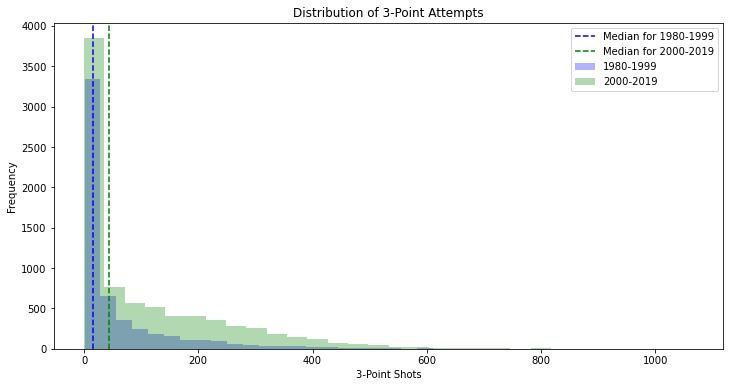

In [55]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(pre_rule['3PA'], bins=30, color='blue', alpha=0.3, label='1980-1999')
ax.hist(post_rule['3PA'], bins=30, color='green', alpha=0.3, label='2000-2019')

ax.axvline(pre_rule['3PA'].median(), color='blue', linestyle='dashed', label='Median for 1980-1999')
ax.axvline(post_rule['3PA'].median(), color='green', linestyle='dashed', label='Median for 2000-2019')

ax.set_title('Distribution of 3-Point Attempts')
ax.set_xlabel('3-Point Shots')
ax.set_ylabel('Frequency')

ax.legend();

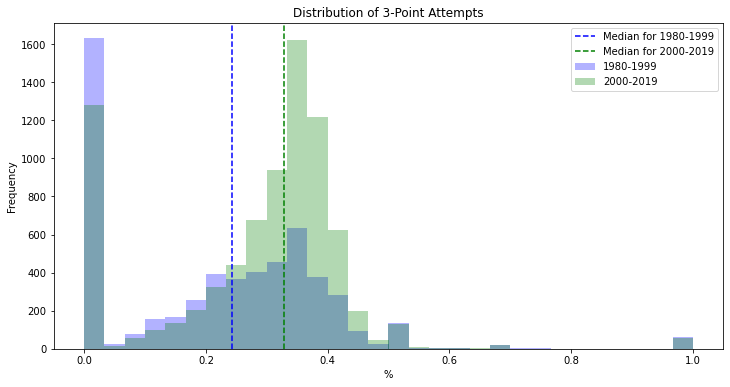

In [56]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(pre_rule['3P%'], bins=30, color='blue', alpha=0.3, label='1980-1999')
ax.hist(post_rule['3P%'], bins=30, color='green', alpha=0.3, label='2000-2019')

ax.axvline(pre_rule['3P%'].median(), color='blue', linestyle='dashed', label='Median for 1980-1999')
ax.axvline(post_rule['3P%'].median(), color='green', linestyle='dashed', label='Median for 2000-2019')

ax.set_title('Distribution of 3-Point Attempts')
ax.set_xlabel('%')
ax.set_ylabel('Frequency')

ax.legend();

__The 3-point line was implemented in 1980, so players from the early 1980's were not used to shooting from that far away. Number of 3-point attempts and 3-point percentages increased.__

# Build Model

In [57]:
# Five-second rule implementation in 1999-2000
# Use PCA to reduce dimensions and then cluster

In [66]:
data = post_rule.drop(['Year', 'Player'], axis=1)

In [67]:
data

,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,...,Pos_PG,Pos_PG-SF,Pos_PG-SG,Pos_SF,Pos_SF-PF,Pos_SF-SG,Pos_SG,Pos_SG-PF,Pos_SG-PG,Pos_SG-SF
5578,82.0,82.0,1929.0,173.0,387.0,0.447028,1.0,4.0,0.250000,172.0,...,0,0,0,0,0,0,0,0,0,0
5579,82.0,14.0,1952.0,244.0,593.0,0.411467,44.0,121.0,0.363636,200.0,...,0,0,0,0,0,0,1,0,0,0
5580,81.0,0.0,1545.0,235.0,450.0,0.522222,0.0,3.0,0.000000,235.0,...,0,0,0,0,0,0,0,0,0,0
5581,62.0,3.0,604.0,53.0,130.0,0.407692,0.0,1.0,0.000000,53.0,...,0,0,0,0,0,0,0,0,0,0
5582,72.0,47.0,1927.0,175.0,413.0,0.423729,16.0,57.0,0.280702,159.0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13719,77.0,0.0,17.6,2.5,5.2,0.480769,0.5,1.6,0.312500,1.9,...,0,0,0,0,0,0,0,0,0,0
13720,63.0,62.0,34.5,8.4,18.0,0.466667,1.9,5.1,0.372549,6.5,...,0,0,0,0,0,0,1,0,0,0
13721,68.0,3.0,12.9,1.3,2.8,0.464286,0.0,0.1,0.000000,1.3,...,0,0,0,0,0,0,0,0,0,0
13722,6.0,2.0,18.5,2.3,5.7,0.403509,1.0,2.7,0.370370,1.3,...,0,0,0,0,0,0,1,0,0,0


In [68]:
y_pred = KMeans(n_clusters=5, random_state=1).fit_predict(data)

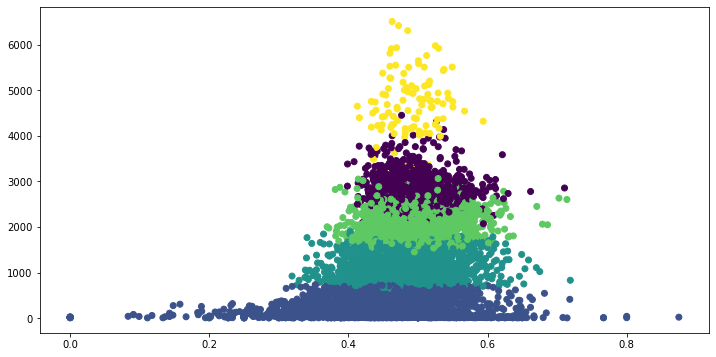

In [70]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(data['eFG%'], data['MP'], c=y_pred);

In [52]:
data_scaled = StandardScaler().fit_transform(data)

In [53]:
pca = PCA(n_components=10).fit(data_scaled)

In [54]:
def scree_plot(ax, pca, n_components_to_plot=8, title=None):
    num_components = pca.n_components_
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
    ax.plot(ind, vals, color='blue')
    ax.scatter(ind, vals, color='blue', s=50)
    for i in range(num_components):
        ax.annotate(r"{:2.2f}".format(vals[i]),
                    (ind[i]+0.2, vals[i]+0.005),
                    va="bottom", ha="center", fontsize=12)
    ax.set_xticklabels(ind, fontsize=12)
    ax.set_ylim(0, max(vals) + 0.05)
    ax.set_xlim(0 - 0.45, n_components_to_plot + 0.45)
    ax.set_xlabel("Principal Component", fontsize=12)
    ax.set_ylabel("Variance Explained", fontsize=12)
    if title is not None:
        ax.set_title(title, fontsize=16)

In [56]:
data.columns

Index(['Age', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P',
       '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST',
       'STL', 'BLK', 'TOV', 'PF', 'PTS'],
      dtype='object')

In [66]:
PCA_components = pca.components_[0:2]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()


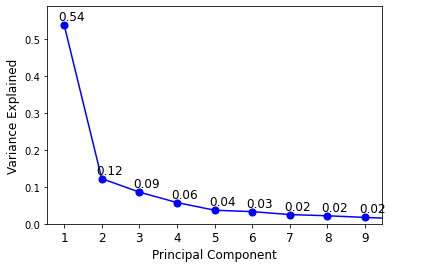

In [36]:
fig, ax = plt.subplots()
scree_plot(ax, pca);

Text(0, 0.5, 'PCA 2')

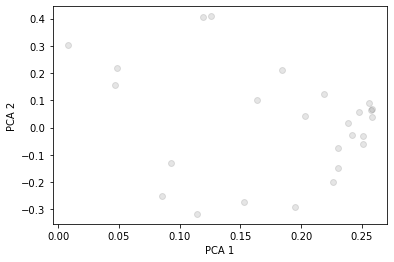

In [69]:
plt.scatter(PCA_components[0], PCA_components[1], alpha=.1, color='black')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')